f = 0.2768016068074532


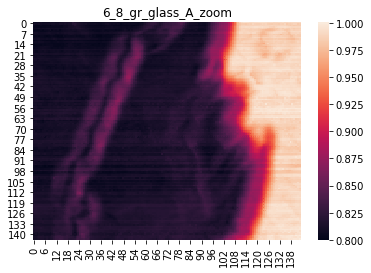

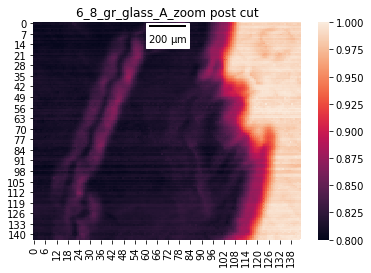

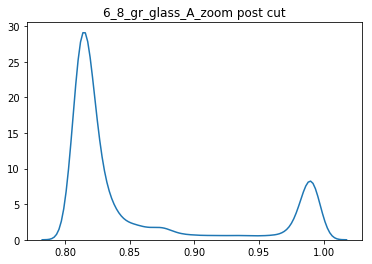

How many peaks are present? 2
Enter peak amp: 29
Enter peak center: 0.81
Enter peak amp: 9
Enter peak center: 0.98


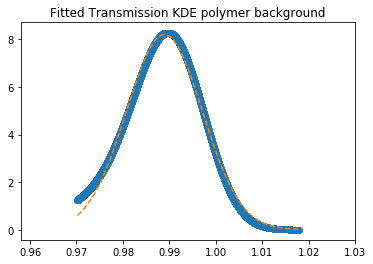

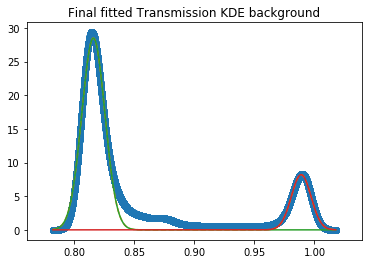

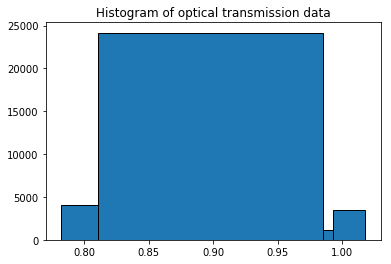

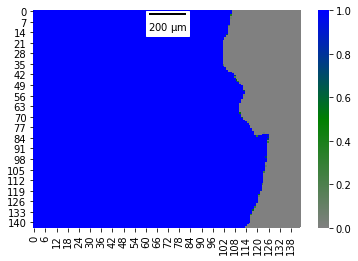

peak 0 center = 0.8158612062344084
delta T peak 1 - 0 = 0.17305672796897842
peak 1 center = 0.9889179342033868
gr coverage via bins = 0.9549998024574295
gr coverage via peak area = 0.8033908784498819
gr coverage via peak amp = 0.7765259446254393
gr coverage via probability = 0.7948949292328101


In [2]:
# Code to calculate presence of graphene based on experimentally measured transmission values. 
# Sample data are used to calculated PDF via KDE. Peaks in KDE are fit to Gaussian curves. Width of lower 
# transmission peak is used to determine single layer gr coverage. Width of higher transmission and all other data are assumed 
# to be background eg polymer. Histogram and discrete layer number assignments are made from these widths. Gr 
# coverage is calculated from bins in bin widths, peak area ratio, and peak height ratio

%matplotlib inline
%run get_heatmap.ipynb

#Import necessary packages
import numpy as np; import pandas as pd; import seaborn as sb; import matplotlib.pyplot as plt;
import statsmodels.api as sm; from scipy.optimize import curve_fit; import scipy.stats as stats; 
import statsmodels.stats.proportion as smsp; from matplotlib.colors import LinearSegmentedColormap; 
from matplotlib_scalebar.scalebar import ScaleBar;

def bootstrap(data):
    sampleProps=[]; data=np.sort(data);
    for _ in range(10000):
        samples=np.random.choice(data,size=len(data),replace=True);
        sampleProps.append(samples.mean());
    return np.mean(sampleProps), np.std(sampleProps), np.percentile(sampleProps,[2.5,97.5])

def gauss(x,*params):
    y=np.zeros_like(x);
    for i in range(0,len(params),3):
        a=params[i]; x0=params[i+1]; sigma=params[i+2];
        y=y+a*np.exp(-(x-x0)**2/(2*sigma**2));
    return y

def gaussArea(a,sigma):
    return a*sigma*np.pi**(0.5)

# 10 layers of graphene on PET: step = 50 um, beam radius = 7 um, file = 10_gr_PET
# 6-8 layers of graphene on glass (A): step = 100 um, beam radius ~ 8 um, file = 6_8_gr_glass_A
# 6-8 layers of graphene on glass (logo): step = 55 um, beam radius  = 7.3 um, file = 6_8_gr_glass_logo

# Import data. Correct for background. Get heatmap
path='/Users/ajcjake/Desktop/Technique Paper/Laser Scan Data/Graphene Experimental Data/'; 
samp='6_8_gr_glass_A_zoom'; 
pix=10; pixum=0.01;
data=pd.read_csv(path+samp+'.csv',sep=',');
# Background correction for objective lens. f ~ 0.42
idx=data['Detected_Power'].idxmax(); Ins=data['Detected_Power'].iloc[idx]; Iinc=data['Incident_Power'].iloc[idx];
f=(3/2)*Ins/Iinc; print('f = '+str(f));
data['T']=data['Detected_Power']/((2/3)*f*data['Incident_Power']);
dataArray=get_heatmap(data,pixum,'T');
# Cut non-measured area. Display full image
idxR1=0; idxR2=-1; idxC1=0; idxC2=-1; dataArray=dataArray.iloc[idxR1:idxR2,idxC1:idxC2].values;
plt.title(samp); plt.show(sb.heatmap(dataArray));
# Cut non-sample data. Display heatmap and KDE
sampArray=dataArray;
thrs1=0.65; idx=np.where(sampArray<thrs1); sampArray[idx]=np.nan;
thrs2=1.00; idx=np.where(sampArray>thrs2); sampArray[idx]=np.nan;

np.savetxt(path+samp+'_rawDataArray.csv',dataArray,delimiter=',');
np.savetxt(path+samp+'_cleanedDataArray.csv',sampArray,delimiter=',');
np.savetxt(path+samp+'_thrsIndices.csv',np.hstack((idxR1,idxR2,idxC1,idxC2,thrs1,thrs2)),delimiter=',');
ax1=sb.heatmap(sampArray); ax1.set_title(samp+' post cut');
ax1.add_artist(ScaleBar(pix,units='um',location='upper center'));
plt.show()

flatArray=sampArray[~np.isnan(sampArray)];
plt.title(samp+' post cut'); plt.show(sb.kdeplot(flatArray));

# Calculate probability density functions for both background and sample data
kde=sm.nonparametric.KDEUnivariate(flatArray); kde.fit();

# Remain x and y KDE data for fitting process. Plot KDE to determine number of peaks present for fitting process
xGauss=kde.support; yGauss=kde.density;
sortIdx=np.argsort(xGauss); xGauss=xGauss[sortIdx]; yGauss=yGauss[sortIdx];
n=int(input('How many peaks are present? ')); initParams=np.ones(3*n); xCen=np.ones(n);
for m in range(0,3*n,3):
    a=input('Enter peak amp: '); x0=input('Enter peak center: ');
    initParams[m]=a; initParams[m+1]=x0; initParams[m+2]=0.1;
xCen=initParams[1::3];

# Load boundary values into a tuple by making a list in a list and converting. Fit polymer peak first and 
# check fit
bounds=[]; b1=[0]*3*n; b2=[1]*3*n; bounds.append(b1); bounds.append(b2);
for c,m in enumerate(range(0,3*n,3)):
    bounds[0][m]=0; bounds[0][m+1]=0.98*xCen[c]; bounds[0][m+2]=0;
    bounds[1][m]=np.inf; bounds[1][m+1]=1.03*xCen[c]; bounds[1][m+2]=0.2;
pBounds=tuple(bounds); pBounds1=(pBounds[0][-3:],pBounds[1][-3:]);
idx1=np.where(xGauss>0.99*initParams[-2])[0][0];
sParams1,cov=curve_fit(gauss,xGauss[idx1:],yGauss[idx1:],p0=initParams[-3:],bounds=pBounds1);
plt.title('Fitted Transmission KDE polymer background');
plt.scatter(xGauss[idx1:],yGauss[idx1:],color='C0'); 
plt.plot(xGauss[idx1:],gauss(xGauss[idx1:],*sParams1),ls='--',color='C1'); plt.show()

# Load fitted polymer peak params back into boundary and initial conditions. Fit remaining peaks
initParams2=initParams; initParams2[-3:]=sParams1; 
pBounds2=bounds; pBounds2[0][-3:]=0.9999999*sParams1; pBounds2[1][-3:]=sParams1; pBounds2=tuple(pBounds2);
sParams2,cov=curve_fit(gauss,xGauss,yGauss,p0=initParams2,bounds=pBounds2);
amp=sParams2[0::3]; xCen=sParams2[1::3]; sigma=sParams2[2::3];
np.savetxt(path+samp+'_fitParams.csv',sParams2,delimiter=',');
np.savetxt(path+samp+'_xPDF.csv',xGauss,delimiter=',');

# Check and save fitting results
plt.title('Final fitted Transmission KDE background');
plt.scatter(xGauss,yGauss,color='C0'); plt.plot(xGauss,gauss(xGauss,*sParams2),ls='--',color='C1');
[plt.plot(xGauss,gauss(xGauss,*np.array([amp[m],xCen[m],sigma[m]])),color='C'+str(m+2)) for m in range(0,n)];
plt.show();
temp=np.zeros((xGauss.shape[0],2)); temp[:,0]=xGauss; temp[:,1]=gauss(xGauss,*sParams1)+gauss(xGauss,*sParams2);
np.savetxt(path+samp+'_fittedPDF.csv',temp,delimiter=',');

# Create bins for hist based on fitted peak centers and widths. Calculate peak areas
bins=[0]*(n+3); bins[0]=xGauss[0]; bins[-1]=xGauss[-1]; bins[-2]=xCen[-1]+sigma[-1]/2; areaDict={};
for m in range(0,n):
    bins[m+1]=xCen[m]-sigma[m]/2;
    areaDict[m]=gaussArea(amp[m],sigma[m]);

plt.title('Histogram of optical transmission data');
binCounts,_,_=plt.hist(xGauss,bins=bins,edgecolor='k'); plt.show();

binCov=binCounts[1:n].sum()/binCounts[1:n+1].sum();
grPeaks=np.array([areaDict[k] for k in np.arange(0,n-1)]); polyPeak=areaDict[n-1];
peakCov=grPeaks.sum()/(grPeaks.sum()+polyPeak);
ampCov=amp[:-1].sum()/(amp.sum());

# Caculate probability of 1 layer of graphene being present based on fitted Gaussian peaks and individual 
# pixel T values
pDict={}; grPeaks=[]; polyPeak=[];
for m in range(0,n):
    pDict[m]=gauss(sampArray,*np.array([amp[m],xCen[m],sigma[m]]));
grPeaks=np.array([pDict[k] for k in np.arange(0,n-1)]); polyPeak=pDict[n-1];
sumGrPeaks=np.zeros(grPeaks.shape[1:]);
for m in range(0,grPeaks.shape[0]):
    sumGrPeaks+=grPeaks[m];
pLayArray=sumGrPeaks/(polyPeak+sumGrPeaks); pCov=np.nanmean(pLayArray);
#LayArray=p1/(p1+p2); pCov=np.nanmean(pLayArray)
np.savetxt(path+samp+'_layerArray.csv',pLayArray,delimiter=',');

flatArray=pLayArray[~np.isnan(pLayArray)];
avg,std,c=bootstrap(flatArray); intL=c[0]; intU=c[1];
np.savetxt(path+samp+'_pgrCov.csv',np.vstack((pCov,intL,intU)),delimiter=',');

cmap=LinearSegmentedColormap.from_list("", ["gray","green","blue"])
ax2=sb.heatmap(pLayArray,cmap=cmap); 
ax2.add_artist(ScaleBar(pix,units='um',location='upper center'));
plt.show();

for n in range(1,len(xCen)+1):
    print('peak '+str(n-1)+' center = '+str(xCen[n-1]));
    try:
        print('delta T peak '+str(n)+' - '+str(n-1)+' = '+str(xCen[n]-xCen[n-1]));
    except:
        pass

print('gr coverage via bins = '+str(binCov));
print('gr coverage via peak area = '+str(peakCov));
print('gr coverage via peak amp = '+str(ampCov));
print('gr coverage via probability = '+str(pCov));

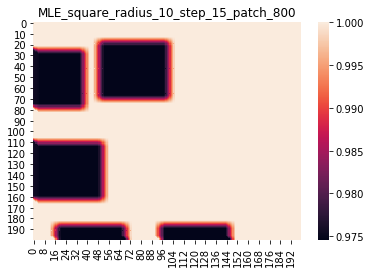

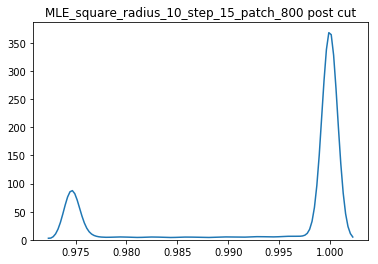

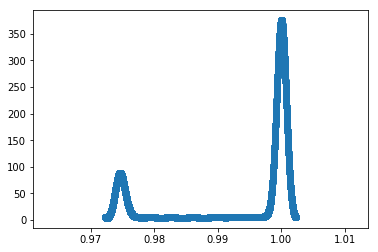

How many peaks are present? 2
Enter peak amp: 100
Enter peak center: 0.97
Enter peak amp: 375
Enter peak center: 1


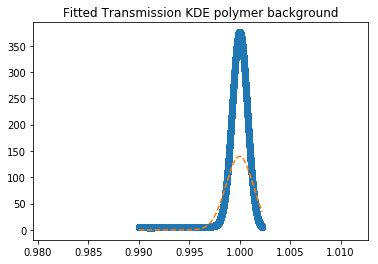

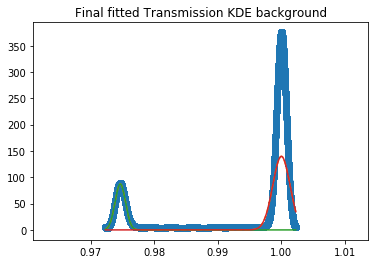

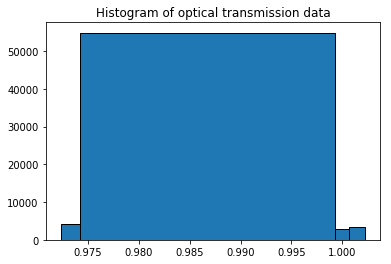

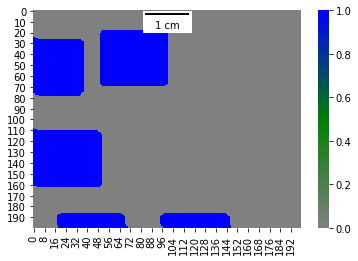

peak 1 center = 0.9746619879412274
delta T peak 1 - 0 = 0.02533121991789511
peak 2 center = 0.9999932078591225
gr coverage via bins = 0.9486895788672982
gr coverage via peak area = 0.2739762968469068
gr coverage via peak amp = 0.38454262487585766
gr coverage via probability = 0.2141895835855446


In [15]:
# Code to calculate presence of graphene based on simulated transmission values. 
# Sample data are used to calculated PDF via KDE. Peaks in KDE are fit to Gaussian curves. Width of lower 
# transmission peak is used to determine single layer gr coverage. Width of higher transmission and all other data are assumed 
# to be background eg polymer. Histogram and discrete layer number assignments are made from these widths. Gr 
# coverage is calculated from bins in bin widths, peak area ratio, and peak height ratio

%matplotlib inline
%run get_heatmap.ipynb

#Import necessary packages
import numpy as np; import pandas as pd; import seaborn as sb; import matplotlib.pyplot as plt;
import statsmodels.api as sm; from scipy.optimize import curve_fit; import scipy.stats as stats; 
import statsmodels.stats.proportion as smsp; from matplotlib.colors import LinearSegmentedColormap; 
from matplotlib_scalebar.scalebar import ScaleBar;

def bootstrap(data):
    sampleProps=[]; data=np.sort(data);
    for _ in range(10000):
        samples=np.random.choice(data,size=len(data),replace=True);
        sampleProps.append(samples.mean());
    return np.mean(sampleProps), np.std(sampleProps), np.percentile(sampleProps,[2.5,97.5])

def gauss(x,*params):
    y=np.zeros_like(x);
    for i in range(0,len(params),3):
        a=params[i]; x0=params[i+1]; sigma=params[i+2];
        y=y+a*np.exp(-(x-x0)**2/(2*sigma**2));
    return y

def gaussArea(a,sigma):
    return a*sigma*np.pi**(0.5)

# Import data. Correct for background. Get heatmap
#path='/Users/ajcjake/Desktop/Technique Paper/Laser Scan Data/Simulated data/LaserOutput_'; 
#samp='radius_25_step_25';

path='/Users/ajcjake/Desktop/Technique Paper/Laser Scan Data/MLE Analysis/';

sampArray=np.genfromtxt(path+'MLE_square_radius_10_step_15_patch_800.csv',delimiter=',');

samp='MLE_square_radius_10_step_15_patch_800';

#sampArray=np.genfromtxt(path+samp+'.csv',delimiter=',');
plt.title(samp); plt.show(sb.heatmap(sampArray));

flatArray=sampArray[~np.isnan(sampArray)];
plt.title(samp+' post cut'); plt.show(sb.kdeplot(flatArray));

# Calculate probability density functions for both background and sample data
kde=sm.nonparametric.KDEUnivariate(flatArray); kde.fit()

# Rename x and y KDE data for fitting process. Sort data. Plot KDE to determine number of peaks present 
# for fitting process
xGauss=kde.support; yGauss=kde.density;
plt.scatter(xGauss,yGauss);plt.show()
n=int(input('How many peaks are present? ')); initParams=np.ones(3*n); xCen=np.ones(n);
for m in range(0,3*n,3):
    a=input('Enter peak amp: '); x0=input('Enter peak center: ');
    initParams[m]=a; initParams[m+1]=x0; initParams[m+2]=0.01;
xCen=initParams[1::3];

# Load boundary values into a tuple by making a list in a list and converting. Fit polymer peak first and 
# check fit
bounds=[]; b1=[0]*3*n; b2=[1]*3*n; bounds.append(b1); bounds.append(b2);
for c,m in enumerate(range(0,3*n,3)):
    bounds[0][m]=0; bounds[0][m+1]=0.8*xCen[c]; bounds[0][m+2]=0;
    bounds[1][m]=np.inf; bounds[1][m+1]=1.2*xCen[c]; bounds[1][m+2]=0.2;
pBounds=tuple(bounds); pBounds1=(pBounds[0][-3:],pBounds[1][-3:]);
idx1=np.where(xGauss>0.99*initParams[-2])[0][0];
sParams1,cov=curve_fit(gauss,xGauss[idx1:],yGauss[idx1:],p0=initParams[-3:],bounds=pBounds1);
plt.title('Fitted Transmission KDE polymer background');
plt.scatter(xGauss[idx1:],yGauss[idx1:],color='C0'); 
plt.plot(xGauss[idx1:],gauss(xGauss[idx1:],*sParams1),ls='--',color='C1'); plt.show()

# Load fitted polymer peak params back into boundary and initial conditions. Fit remaining peaks
initParams2=initParams; initParams2[-3:]=sParams1; 
pBounds2=bounds; pBounds2[0][-3:]=0.9999999*sParams1; pBounds2[1][-3:]=sParams1; pBounds2=tuple(pBounds2);
sParams2,cov=curve_fit(gauss,xGauss,yGauss,p0=initParams2,bounds=pBounds2);
amp=sParams2[0::3]; xCen=sParams2[1::3]; sigma=sParams2[2::3];
np.savetxt(path+samp+'_fitParams.csv',sParams2,delimiter=',');
np.savetxt(path+samp+'_xPDF.csv',xGauss,delimiter=',');

# Check and save fitting results
plt.title('Final fitted Transmission KDE background');
plt.scatter(xGauss,yGauss,color='C0'); plt.plot(xGauss,gauss(xGauss,*sParams2),ls='--',color='C1');
[plt.plot(xGauss,gauss(xGauss,*np.array([amp[m],xCen[m],sigma[m]])),color='C'+str(m+2)) for m in range(0,n)];
plt.show();
temp=np.zeros((xGauss.shape[0],2)); temp[:,0]=xGauss; temp[:,1]=gauss(xGauss,*sParams1)+gauss(xGauss,*sParams2);
np.savetxt(path+samp+'_fittedPDF.csv',temp,delimiter=',');

# Create bins for hist based on fitted peak centers and widths. Calculate peak areas
bins=[0]*(n+3); bins[0]=xGauss[0]; bins[-1]=xGauss[-1]; bins[-2]=xCen[-1]+sigma[-1]/2; areaDict={};
for m in range(0,n):
    bins[m+1]=xCen[m]-sigma[m]/2;
    areaDict[m]=gaussArea(amp[m],sigma[m]);

plt.title('Histogram of optical transmission data');
binCounts,_,_=plt.hist(xGauss,bins=bins,edgecolor='k'); plt.show();

binCov=binCounts[1:n].sum()/binCounts[1:n+1].sum();
grPeaks=np.array([areaDict[k] for k in np.arange(0,n-1)]); polyPeak=areaDict[n-1];
peakCov=grPeaks.sum()/(grPeaks.sum()+polyPeak);
ampCov=amp[:-1].sum()/(amp.sum());

# Caculate probability of 1 layer of graphene being present based on fitted Gaussian peaks and individual pixel T values
pDict={}; grPeaks=[]; polyPeak=[];
for m in range(0,n):
    pDict[m]=gauss(sampArray,*np.array([amp[m],xCen[m],sigma[m]]));
grPeaks=np.array([pDict[k] for k in np.arange(0,n-1)]); polyPeak=pDict[n-1];
sumGrPeaks=np.zeros(grPeaks.shape[1:]);
for m in range(0,grPeaks.shape[0]):
    sumGrPeaks+=grPeaks[m];
pLayArray=sumGrPeaks/(polyPeak+sumGrPeaks); pCov=np.nanmean(pLayArray);
np.savetxt(path+samp+'_layerArray.csv',pLayArray,delimiter=',');

flatArray=pLayArray[~np.isnan(pLayArray)];
avg,std,c=bootstrap(flatArray); intL=c[0]; intU=c[1];
np.savetxt(path+samp+'_pgrCov.csv',np.vstack((pCov,intL,intU)),delimiter=',');

cmap=LinearSegmentedColormap.from_list("", ["gray","green","blue"])
ax2=sb.heatmap(pLayArray,cmap=cmap); 
ax2.add_artist(ScaleBar(300,units='um',location='upper center'));
plt.show();

for n in range(0,len(xCen)):
    print('peak '+str(n+1)+' center = '+str(xCen[n]));
    try:
        print('delta T peak '+str(n+1)+' - '+str(n)+' = '+str(xCen[n+1]-xCen[n]));
    except:
        pass

print('gr coverage via bins = '+str(binCov));
print('gr coverage via peak area = '+str(peakCov));
print('gr coverage via peak amp = '+str(ampCov));
print('gr coverage via probability = '+str(pCov));

In [ ]:
# Code to fix stripes in collected optical transmission data

%matplotlib inline
%run get_heatmap.ipynb

#Import necessary packages
import numpy as np; import seaborn as sb; import matplotlib.pyplot as plt; import pandas as pd;

# Import data. Correct for background. Get heatmap
path='/Users/ajcjake/Desktop/Technique Paper/Laser Scan Data/Graphene experimental data/'; 
# beam = 7 um, step size = 50 um
samp='10_gr_PET'; pix=50; pixum=0.05;
data=pd.read_csv(path+samp+'.csv',sep=',');
# Background correction for objective lens. f ~ 0.42
idx=data['Detected_Power'].idxmax(); Ins=data['Detected_Power'].iloc[idx]; Iinc=data['Incident_Power'].iloc[idx];
f=(3/2)*Ins/Iinc; print('f = '+str(f));
data['T']=data['Detected_Power']/((2/3)*f*data['Incident_Power']);
dataArray=get_heatmap(data,pixum,'T');

# Cut non-measured area. Display full image
idxR1=40; idxR2=-1; idxC1=30; idxC2=-1; dataArray=dataArray.iloc[idxR1:idxR2,idxC1:idxC2].values;
plt.title(samp); plt.show(sb.heatmap(dataArray));
# Cut non-sample data. Display heatmap and KDE
sampArray=dataArray;
#thrs1=0.70; idx=np.where(sampArray<thrs1); sampArray[idx]=np.nan;
#thrs2=1.00; idx=np.where(sampArray>thrs2); sampArray[idx]=np.nan;

row,col=sampArray.shape;
test=sampArray; ref=1; print('ref = ',ref)

for r in range(0,row):
    cf=ref-sampArray[r,-1];
    test[r,:]+=cf
print('last cf = ',cf)
sb.heatmap(test); plt.title(samp+' post analysis'); plt.show()

In [ ]:
# This code fixes raw Raman data files

import numpy as np; import matplotlib.pyplot as plt; import seaborn as sb;

path='/Users/ajcjake/Desktop/Technique Paper/Raman Data/';



In [ ]:
# This code loads the laser beam set up frequency and accumulation data, places it into a manageable pandas 
# dataframe, and saves the dataframe for later analysis using seaborn

%matplotlib inline

import numpy as np; import pandas as pd;

path='/Users/ajcjake/Desktop/Technique Paper/Laser Scan Data/Setup Data/';
fList=[25,50,75,100,200,300,400,500]; nList=[25,50,75,100]; 
dfMaster=pd.DataFrame(columns=['Transmission','Accumulations','Frequency']);
dfFrac=pd.DataFrame(columns=['Fractional Standard Deviation','Accumulations','Frequency']); counter=0;

for f in fList:
    for n in nList:
        try:
            a=np.genfromtxt(path+'f'+str(f)+'n'+str(n)+'.csv',skip_header=True,delimiter=',');
            tData=a[:,3]/a[:,2]; 
            df=pd.DataFrame(tData,columns=['Transmission']);
            freq=np.zeros(tData.shape[0])+f; accum=np.zeros(tData.shape[0])+n;
            df['Accumulations']=accum; df['Frequency']=freq;
            dfMaster=dfMaster.append(df);
            
            frac=[];
            frac.append(tData.std()/tData.mean()); frac.append(n); frac.append(f);
            dfFrac.loc[counter]=frac
            counter+=1;
        except:
            pass

dfMaster.to_csv(path+'masterFreqN.csv',index=False);   
dfFrac.to_csv(path+'fracFreqN.csv',index=False);

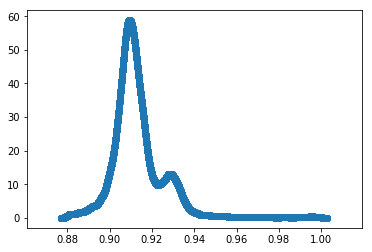

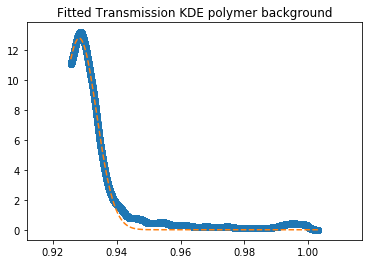

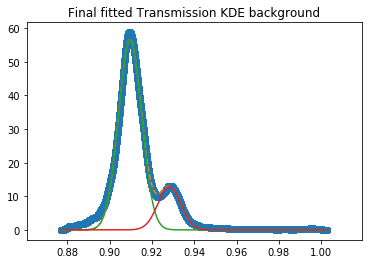

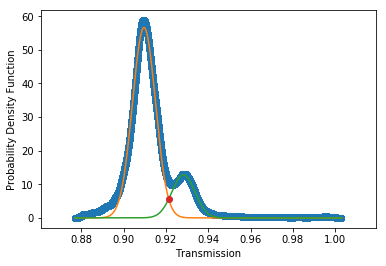

0.8175940284385103


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in greater


In [4]:
# This code calculated graphene coverage for the cross sample using a plain transmission cut off. The cut off is
# determined by the intersection of the graphene/polymer and polymer peaks in the fitted PDF for the highest
# resolution data set. The code then counts the number of pixels below that threshold and divides them by the total
# number of pixels to obtain a grapheen coverage fraction, similar to image analysis

%matplotlib inline

import numpy as np; import matplotlib.pyplot as plt; import seaborn as sb; from scipy.optimize import curve_fit;
import matplotlib as mpl; plt.rcParams.update({'font.size': 10}); import matplotlib.transforms as transforms;
from matplotlib_scalebar.scalebar import ScaleBar; import statsmodels.api as sm;

def gauss(x,*params):
    y=np.zeros_like(x);
    for i in range(0,len(params),3):
        a=params[i]; x0=params[i+1]; sigma=params[i+2];
        y=y+a*np.exp(-(x-x0)**2/(2*sigma**2));
    return y

path='/Users/ajcjake/Desktop/Technique Paper/Laser Scan Data/Cross Experimental Data/'; # beam radius = 7.7 um
cov=[]; # Array for calculated coverage info. Actual coverage via ImageJ = 0.81825927734375

step50=np.genfromtxt(path+'Gr_PVB_cross_50um_cleanedDataArray.csv',delimiter=',');
flatArray=step50[~np.isnan(step50)];

# Calculate probability density functions for both background and sample data
kde=sm.nonparametric.KDEUnivariate(flatArray); kde.fit()

# Rename x and y KDE data for fitting process. Sort data. Plot KDE to determine number of peaks present 
# for fitting process
xGauss=kde.support; yGauss=kde.density;
plt.scatter(xGauss,yGauss);plt.show()
#n=int(input('How many peaks are present? ')); initParams=np.ones(3*n); xCen=np.ones(n);
n=2; initParams=np.ones(3*n); xCen=np.ones(n);
a=[60,20]; x0=[0.91,0.935];
for i,m in enumerate(range(0,3*n,3)):
    #a=input('Enter peak amp: '); x0=input('Enter peak center: ');
    initParams[m]=a[i]; initParams[m+1]=x0[i]; initParams[m+2]=0.01;
xCen=initParams[1::3];

# Load boundary values into a tuple by making a list in a list and converting. Fit polymer peak first and 
# check fit
bounds=[]; b1=[0]*3*n; b2=[1]*3*n; bounds.append(b1); bounds.append(b2);
for c,m in enumerate(range(0,3*n,3)):
    bounds[0][m]=0; bounds[0][m+1]=0.8*xCen[c]; bounds[0][m+2]=0;
    bounds[1][m]=np.inf; bounds[1][m+1]=1.2*xCen[c]; bounds[1][m+2]=0.1;
pBounds=tuple(bounds); pBounds1=(pBounds[0][-3:],pBounds[1][-3:]);
idx1=np.where(xGauss>0.99*initParams[-2])[0][0];
sParams1,cov=curve_fit(gauss,xGauss[idx1:],yGauss[idx1:],p0=initParams[-3:],bounds=pBounds1);
plt.title('Fitted Transmission KDE polymer background');
plt.scatter(xGauss[idx1:],yGauss[idx1:],color='C0'); 
plt.plot(xGauss[idx1:],gauss(xGauss[idx1:],*sParams1),ls='--',color='C1'); plt.show()

# Load fitted polymer peak params back into boundary and initial conditions. Fit remaining peaks
initParams2=initParams; initParams2[-3:]=sParams1; 
pBounds2=bounds; pBounds2[0][-3:]=0.9999999*sParams1; pBounds2[1][-3:]=sParams1; pBounds2=tuple(pBounds2);
sParams2,cov=curve_fit(gauss,xGauss,yGauss,p0=initParams2,bounds=pBounds2);
amp=sParams2[0::3]; xCen=sParams2[1::3]; sigma=sParams2[2::3];

# Check fitting results and find intersection point
plt.title('Final fitted Transmission KDE background');
plt.scatter(xGauss,yGauss,color='C0'); plt.plot(xGauss,gauss(xGauss,*sParams2),ls='--',color='C1');
[plt.plot(xGauss,gauss(xGauss,*np.array([amp[m],xCen[m],sigma[m]])),color='C'+str(m+2)) for m in range(0,n)];
plt.show();

yGauss1=gauss(xGauss,*np.array([amp[0],xCen[0],sigma[0]])); yGauss2=gauss(xGauss,*np.array([amp[1],xCen[1],sigma[1]]));
idx=np.argwhere(np.diff(np.sign(yGauss1 - yGauss2))).flatten(); xInt=xGauss[idx];
plt.scatter(xGauss,yGauss,color='C0');
plt.plot(xGauss,yGauss1,color='C1');
plt.plot(xGauss,yGauss2,color='C2'); plt.scatter(xInt,yGauss1[idx],color='C3',zorder=15); 
plt.ylabel('Probability Density Function'); plt.xlabel('Transmission');plt.show()

# Calculate graphene coverage via pixel number analysis
step50Raw=np.genfromtxt(path+'Gr_PVB_cross_50um_RawDataArray.csv',delimiter=',');
flatArray=step50.flatten();

# Remove pixels under heatmap analysis threshold, ie 0.88. Count pixels with transmissions less than calculated
# intersection transmission
idx=np.argwhere(flatArray>0.88); flatArray=flatArray[idx];
idxL=np.argwhere(flatArray<xInt);
grCov=idxL.shape[0]/flatArray.shape[0]
print(grCov)

In [ ]:
# This code loads and plots random graphene patch analysis

import numpy as np; import matplotlib.pyplot as plt; import seaborn as sb;
from matplotlib_scalebar.scalebar import ScaleBar; import statsmodels.api as sm;

path='/Users/ajcjake/Desktop/Technique Paper/Laser Scan Data/MLE Analysis/';

stepList=['15']; patchList=['100','200','300','400','500','600','700','800'];

for step in stepList:
    for patch in patchList:
        fig,(ax1,ax2)=plt.subplots(1,2,figsize=(7,3)); plt.subplots_adjust(wspace=0.32);
        data=np.genfromtxt(path+'MLE_square_radius_10_step_'+step+'_patch_'+patch+'.csv',delimiter=',');
        sb.heatmap(data,vmin=0.975,vmax=1,ax=ax1); ax1.set_title('step = '+step+' um,\n patch length = '+patch+' um');
        ax1.add_artist(ScaleBar(int(step),units='um'));
        
        kde=sm.nonparametric.KDEUnivariate(data.flatten()); kde.fit(); 
        xGauss=kde.support; yGauss=kde.density; 
        sortIdx=np.argsort(xGauss);xGauss=xGauss[sortIdx];yGauss=yGauss[sortIdx];
        
        ax2.plot(xGauss,yGauss); ax2.set_title('PDF: step = '+step+' um,\n patch length =